## Similarity-based RUL Prediction

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
# os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

In [2]:
def prepare_data():
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1
    
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
sc = MinMaxScaler(feature_range=(0,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])

In [6]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [7]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


### Selecting features using Trendability

\begin{equation*}
Trendability \ (x) = | \frac{1}{M} \sum_{j=1}^{M} \ corr(x_j, t_j) |
\end{equation*}

Finding the average correlation of features with time.

Where j is unit.

In [8]:
def trendability(col):
    
    trend_vals = []
    
    for i in df_train.UnitNumber.unique():
        dff = df_train[df_train.UnitNumber == i]
        trend_vals.append(dff[['Cycle', col]].corr().iloc[0][1])
        
    return np.abs(np.mean(trend_vals))

In [9]:
trend_df = pd.DataFrame(columns = ['feature', 'trendability_val'])

for col in feats:
    trend_df = trend_df.append({'feature': col, 'trendability_val': trendability(col)}, ignore_index = True)

In [10]:
trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

,feature,trendability_val
13,SensorMeasure11,0.810601
14,SensorMeasure12,0.789662
6,SensorMeasure4,0.781614
9,SensorMeasure7,0.761514
17,SensorMeasure15,0.724844


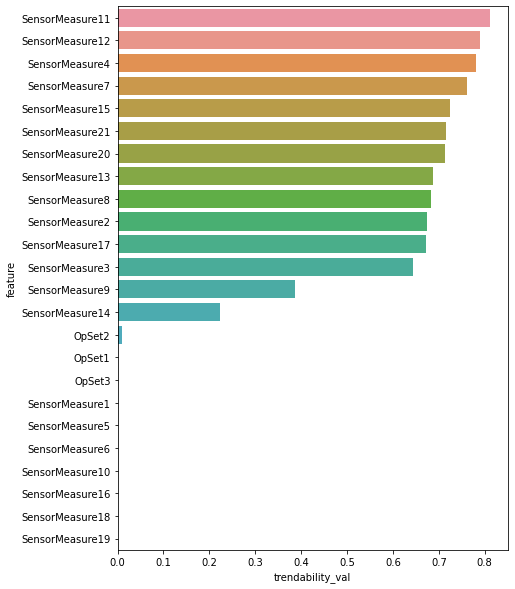

In [11]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)

Selecting features having trendability higher than 0.2

In [12]:
feats = trend_df.feature[trend_df.trendability_val > 0.2]
feats

13    SensorMeasure11
14    SensorMeasure12
6      SensorMeasure4
9      SensorMeasure7
17    SensorMeasure15
23    SensorMeasure21
22    SensorMeasure20
15    SensorMeasure13
10     SensorMeasure8
4      SensorMeasure2
19    SensorMeasure17
5      SensorMeasure3
11     SensorMeasure9
16    SensorMeasure14
Name: feature, dtype: object

In [13]:
len(feats)

14

### Creating a Linear Degradation model to fuse these features

Let's assume health condition of a unit is degrading linearly which can be achieved by rescaling RUL having 1-0 scale

In [14]:
df_train['HI'] = df_train.groupby('UnitNumber').RUL.transform(lambda x: minmax_scale(x))

Visualizing health indicators of 1-30 units

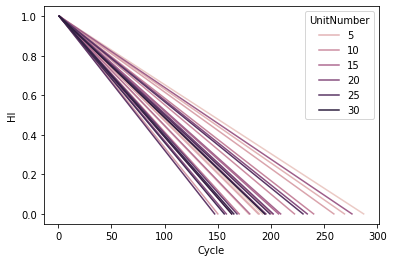

In [15]:
sns.lineplot(data= df_train[df_train.UnitNumber < 31], x = 'Cycle', y = 'HI', hue= 'UnitNumber')

### Fiting a linear regression model of health condition with most trended features.

In [16]:
model = LinearRegression()

In [17]:
X = df_train[feats]
y = df_train.HI

X.shape, y.shape

((20631, 14), (20631,))

In [18]:
model.fit(X,y)

model.score(X,y)

0.6520059883900058

In [19]:
model.coef_

array([-0.26884914,  0.24180177, -0.20064758,  0.18905397, -0.12967532,
        0.13174699,  0.13877304, -0.0241087 ,  0.01229191, -0.08003577,
       -0.10509745, -0.09005357, -0.4145927 , -0.27325302])

In [20]:
len(model.coef_)

14

In [21]:
model.intercept_

0.6333546734289224

### Constructing a new health indicator by multiplying model coefficient with features

In [22]:
df_train['HI_final'] = df_train[feats].dot(model.coef_)
df_train.HI_final.head()

0    0.087893
1    0.077465
2    0.122410
3    0.200864
4    0.071672
Name: HI_final, dtype: float64

Let's visualize final Health Indicators for 1-30 units

Text(0, 0.5, 'Health Indicator')

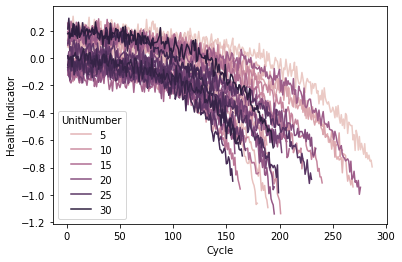

In [23]:
sns.lineplot(data= df_train[df_train.UnitNumber < 31], x = 'Cycle', y = 'HI_final', hue= 'UnitNumber')
plt.ylabel('Health Indicator')

Smoothing the final health indicator to reduce noise.

In [24]:
window = 5

In [25]:
df_train_HI = df_train.groupby('UnitNumber')['HI_final'].rolling(window = window).mean()
df_train_HI = df_train_HI.reset_index()
df_train_HI.dropna(inplace = True)
df_train_HI.drop(['level_1'], axis = 1, inplace = True)
df_train_HI['cycle'] = df_train_HI.groupby('UnitNumber').cumcount()+1
df_train_HI.head()

,UnitNumber,HI_final,cycle
4,1,0.112061,1
5,1,0.125402,2
6,1,0.133693,3
7,1,0.139125,4
8,1,0.128823,5


Visualizing health indicators of all units and their failures

Text(0, 0.5, 'Health Indicator')

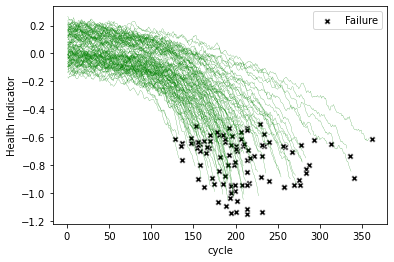

In [26]:
for i in range(1,101):
    sns.lineplot(data= df_train_HI[df_train_HI.UnitNumber == i], x = 'cycle', y = 'HI_final', color = 'green', lw = 0.2)

sns.scatterplot(data = df_train[df_train.HI == 0], x = 'Cycle', y = 'HI_final', label = 'Failure', 
                marker = 'X', color = 'black')
plt.ylabel('Health Indicator')

### Fitting a second order polynomial function on these health indicators


$$ y = \theta_0 + \theta_1  x + \theta_2  x^2 $$

where y is a health indicator and x is a cycle

In [27]:
params_df = pd.DataFrame(columns = ['UnitNumber', 'theta_2', 'theta_1', 'theta_0'])

for i in range(1,101):
    
    y = df_train_HI.HI_final[df_train_HI.UnitNumber == i]
    cycle = df_train_HI.cycle[df_train_HI.UnitNumber == i]

    theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 2)
    
    params_df = params_df.append({'UnitNumber':i, 'theta_0': theta_0, 'theta_1': theta_1, 'theta_2': theta_2},
                                         ignore_index = True)

In [28]:
params_df.head()

,UnitNumber,theta_2,theta_1,theta_0
0,1.0,-0.000026,0.001935,0.081240
1,2.0,-0.000018,0.002209,0.156074
2,3.0,-0.000054,0.004785,0.046752
3,4.0,-0.000049,0.005086,-0.053809
4,5.0,-0.000022,0.002535,0.096549


Visualizing for unit 1

In [29]:
HI = df_train_HI.HI_final[df_train_HI.UnitNumber == 1]
cycle = df_train_HI.cycle[df_train_HI.UnitNumber == 1]

theta_0 = params_df.theta_0[params_df.UnitNumber == 1].values
theta_1 = params_df.theta_1[params_df.UnitNumber == 1].values
theta_2 = params_df.theta_2[params_df.UnitNumber == 1].values

HI_fit = theta_0 + theta_1*cycle + theta_2*cycle*cycle

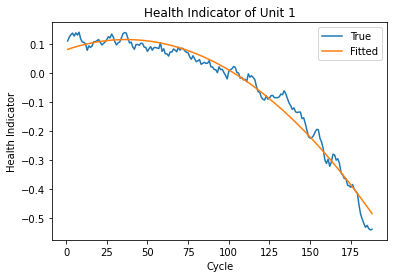

In [30]:
plt.plot(cycle,HI, label = 'True')
plt.plot(cycle,HI_fit, label = 'Fitted')
plt.ylabel('Health Indicator')
plt.xlabel('Cycle')
plt.legend()
plt.title('Health Indicator of Unit 1');

Visualzing for all units

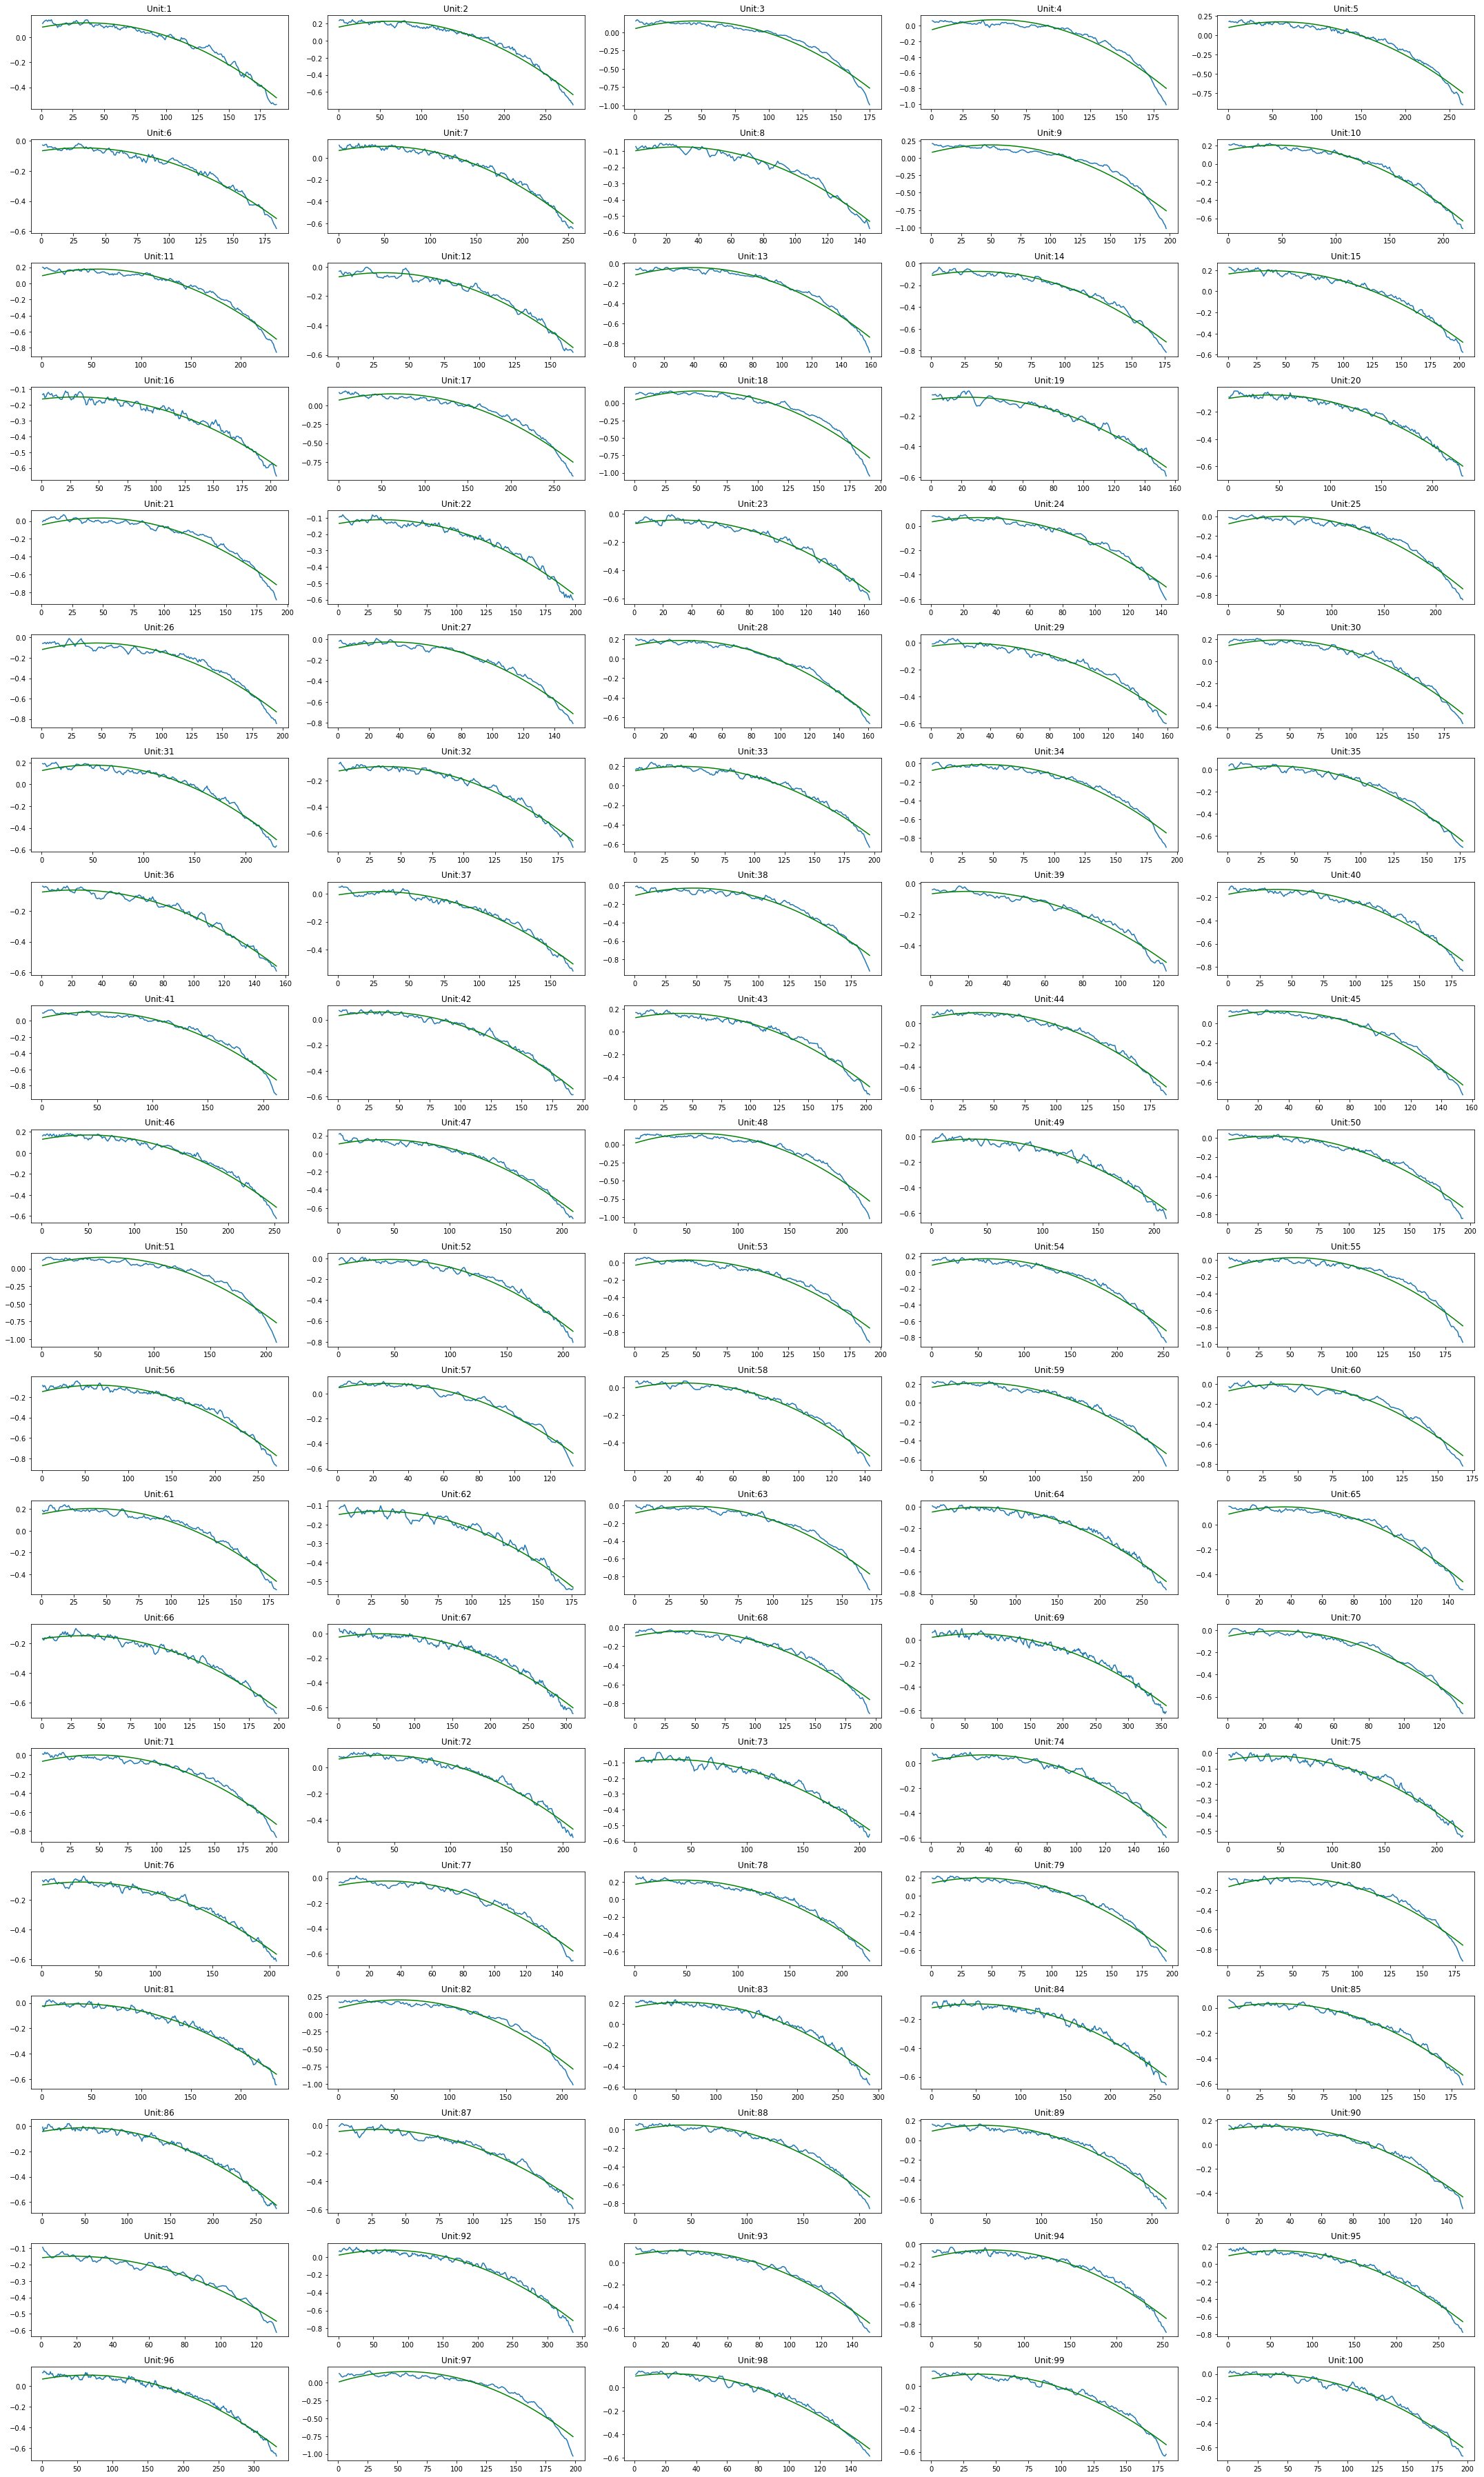

In [31]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    theta_0 = params_df.theta_0[params_df.UnitNumber == i+1].values
    theta_1 = params_df.theta_1[params_df.UnitNumber == i+1].values
    theta_2 = params_df.theta_2[params_df.UnitNumber == i+1].values
    
    cycle = df_train_HI.cycle[df_train_HI.UnitNumber == i+1]
    fit_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
    
    sns.lineplot(data = df_train_HI[df_train_HI.UnitNumber == i+1], x = "cycle", y = "HI_final", ax = ax[i])
    sns.lineplot(y = fit_HI, x = cycle, ax = ax[i], color = "green")
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Building a similartiy based RUL model

Steps:

1. Generate a health indicator by multipying weights to selected features in test data
2. Take a rolling mean of Health Indicator to reduce noise
3. Compare the fitted polynomial models with health indicators of test data and find 1-norm residuals using below equation

    $$ d(i,j) = ||y_j - \hat{y_{j,i}} ||_1 $$
    
4. Find similarity score using following formula

    $$ score(i,j) = exp(-d(i,j)^2) $$
   
5. Find top 50 most similar models
6. Find RUL by subtracting current cycle from total cycles of most similar units

#### Step 1

In [32]:
df_test['HI'] = df_test[feats].dot(model.coef_)
df_test.HI.head()

0    0.095656
1    0.128882
2    0.051068
3    0.087381
4    0.148141
Name: HI, dtype: float64

#### Step 2

In [33]:
df_test_HI = df_test.groupby('UnitNumber')['HI'].rolling(window = window).mean()
df_test_HI = df_test_HI.reset_index()
df_test_HI.dropna(inplace = True)
df_test_HI.drop(['level_1'], axis = 1, inplace = True)
df_test_HI['cycle'] = df_test_HI.groupby('UnitNumber').cumcount()+1
df_test_HI.head()

,UnitNumber,HI,cycle
4,1,0.102226,1
5,1,0.110121,2
6,1,0.103964,3
7,1,0.114302,4
8,1,0.115011,5


#### Step 3 and Step 4

In [34]:
df_test_fit = pd.DataFrame(columns = ['UnitNumber', 'Model', 'Residual', 'similarity', 'total_life'])

for i in df_test_HI.UnitNumber.unique():
    
    HI = df_test_HI.HI[df_test_HI.UnitNumber == i]
    cycle = df_test_HI.cycle[df_test_HI.UnitNumber == i]
        
    for j in params_df.UnitNumber.unique():
        
        theta_0 = params_df.theta_0[params_df.UnitNumber == j].values
        theta_1 = params_df.theta_1[params_df.UnitNumber == j].values
        theta_2 = params_df.theta_2[params_df.UnitNumber == j].values
        
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
        
        Residual = np.mean(np.abs(pred_HI - HI))

        total_life = df_train.Cycle[df_train.UnitNumber == j].max()
        
        similarity_score = np.exp(-Residual*Residual)
        
        df_test_fit = df_test_fit.append({'UnitNumber':i, 'Model': j, 'Residual': Residual, 
                                          'similarity': similarity_score, 'total_life': total_life},
                                         ignore_index = True)


In [35]:
df_test_fit.head()

,UnitNumber,Model,Residual,similarity,total_life
0,1.0,1.0,0.018282,0.999666,192.0
1,1.0,2.0,0.072895,0.994700,287.0
2,1.0,3.0,0.031416,0.999014,179.0
3,1.0,4.0,0.104821,0.989073,189.0
4,1.0,5.0,0.024883,0.999381,269.0


#### Step 5 and 6

*Selecting 5 most similar units*

In [36]:
ind_5 = df_test_fit.groupby('UnitNumber')['similarity'].nlargest(5).reset_index()['level_1']
result_df_5 = df_test_fit.iloc[ind_5]
result_df_5.head()

,UnitNumber,Model,Residual,similarity,total_life
97,1.0,98.0,0.014982,0.999776,156.0
0,1.0,1.0,0.018282,0.999666,192.0
92,1.0,93.0,0.020012,0.999600,155.0
94,1.0,95.0,0.020760,0.999569,283.0
88,1.0,89.0,0.022995,0.999471,217.0


In [38]:
len(result_df_5)

500

Visualizing 5 most similar units to unit 5 of test data

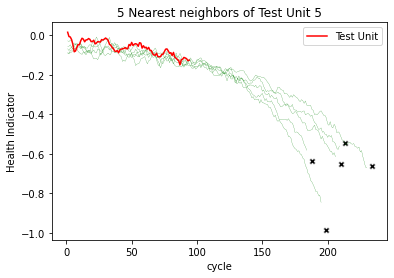

In [41]:
dff = result_df_5[result_df_5.UnitNumber == 3]

for i in dff.Model.unique():
    sns.lineplot(data= df_train_HI[df_train_HI.UnitNumber == i], x = 'cycle', y = 'HI_final', color = 'green', lw = 0.2)
    sns.scatterplot(data = df_train[(df_train_HI.UnitNumber == i) & (df_train.HI == 0)], x = 'Cycle', y = 'HI_final', 
                    marker = 'X', color = 'black')

sns.lineplot(data= df_test_HI[df_test_HI.UnitNumber == 5], x = 'cycle', y = 'HI', color = 'red', 
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('5 Nearest neighbors of Test Unit 5');

#### Step 7

In [42]:
y_true_5 = y_true.copy()

y_true_5['Pred_RUL'] = (result_df_5.groupby('UnitNumber')['total_life'].mean() - df_test.groupby('UnitNumber')['Cycle'].max()).values
y_true_5.head()

,RUL,UnitNumber,Pred_RUL
0,112,1,169.6
1,98,2,161.8
2,69,3,82.8
3,82,4,73.6
4,91,5,73.6


### Results

Text(0, 0.5, 'True RUL')

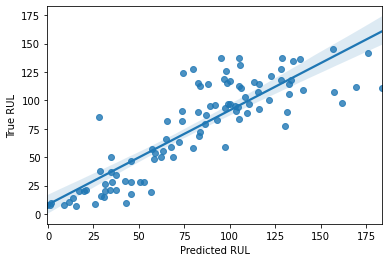

In [50]:
sns.regplot(x = y_true_5.Pred_RUL, y = y_true_5.RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

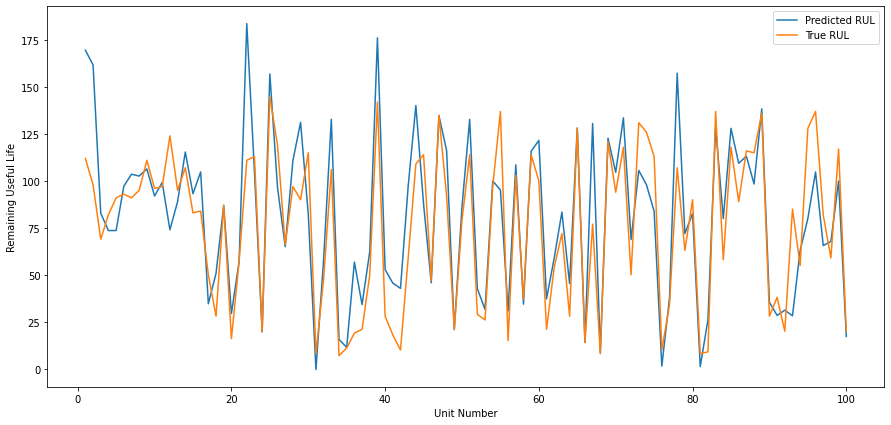

In [51]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_true_5.UnitNumber, y = y_true_5.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_true_5.UnitNumber, y = y_true_5.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [52]:
mean_squared_error(y_true_5.RUL, y_true_5.Pred_RUL)

530.5268000000001

In [53]:
mean_absolute_error(y_true_5.RUL, y_true_5.Pred_RUL)

16.81

In [54]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
mean_absolute_percentage_error(y_true_5.RUL, y_true_5.Pred_RUL)

34.76065468809448